<a href="https://colab.research.google.com/github/jsuk10/MachingLearningHomeWork/blob/master/Project/CustomerPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import sklearn
import missingno as msno

%matplotlib inline

# 데이터 업로드

In [2]:
!git clone --depth 1 https://github.com/jsuk10/MachingLearningHomeWork.git

Cloning into 'MachingLearningHomeWork'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 69 (delta 2), reused 63 (delta 1), pack-reused 0
Unpacking objects: 100% (69/69), done.


In [3]:
os.listdir("/content/MachingLearningHomeWork/Project/data")
datapwd = "/content/MachingLearningHomeWork/Project/data"
train = pd.read_csv (datapwd+"/train.csv") 
test = pd.read_csv (datapwd+"/test.csv")

# 결손치(null값) 확인
각원소들의 count를 비교하고 확인했으나 이상없음
만약 결손이 난다면
train['칼럼이름'].unique()로 다시 확인할 수 있다.


In [4]:
train.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103904.000000,103594.000000
mean,51951.500000,64924.210502,39.379706,1189.448375,2.729683,3.060296,2.756901,2.976883,3.202129,3.250375,3.439396,3.358158,3.382363,3.351055,3.631833,3.304290,3.640428,3.286351,14.815618,15.178678
std,29994.645522,37463.812252,15.114964,997.147281,1.327829,1.525075,1.398929,1.277621,1.329533,1.349509,1.319088,1.332991,1.288354,1.315605,1.180903,1.265396,1.175663,1.312273,38.230901,38.698682
min,0.000000,1.000000,7.000000,31.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25975.750000,32533.750000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.000000,0.000000
50%,51951.500000,64856.500000,40.000000,843.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.000000,0.000000
75%,77927.250000,97368.250000,51.000000,1743.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.000000,13.000000
max,103903.000000,129880.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1592.000000,1584.000000


In [5]:
test.describe()

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
count,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.000000,25976.00000,25893.000000
mean,12987.500000,65005.657992,39.620958,1193.788459,2.724746,3.046812,2.756775,2.977094,3.215353,3.261665,3.449222,3.357753,3.385664,3.350169,3.633238,3.314175,3.649253,3.286226,14.30609,14.740857
std,7498.769632,37611.526647,15.135685,998.683999,1.335384,1.533371,1.412951,1.282133,1.331506,1.355536,1.320090,1.338299,1.282088,1.318862,1.176525,1.269332,1.180681,1.319330,37.42316,37.517539
min,0.000000,17.000000,7.000000,31.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000,0.000000
25%,6493.750000,32170.500000,27.000000,414.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,3.000000,3.000000,2.000000,0.00000,0.000000
50%,12987.500000,65319.500000,40.000000,849.000000,3.000000,3.000000,3.000000,3.000000,3.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000,4.000000,3.000000,0.00000,0.000000
75%,19481.250000,97584.250000,51.000000,1744.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,4.000000,4.000000,4.000000,5.000000,4.000000,5.000000,4.000000,12.00000,13.000000
max,25975.000000,129877.000000,85.000000,4983.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,1128.00000,1115.000000


# 소비자 타입 그래프로 확인

80:18퍼센트 과하게 몰려있지는 않다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


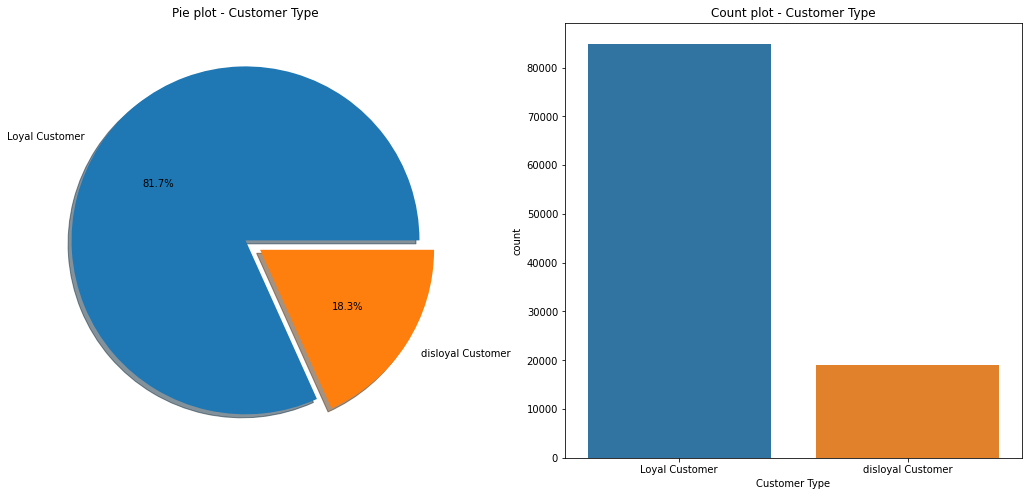

In [6]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

train['Customer Type'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - Customer Type')
ax[0].set_ylabel('')
sns.countplot('Customer Type', data=train, ax=ax[1])
ax[1].set_title('Count plot - Customer Type')

plt.show()

# 데이터 정제
수치 flaot화 하고 maping해준다.

In [7]:
train.dtypes

Unnamed: 0                             int64
id                                     int64
Gender                                object
Customer Type                         object
Age                                    int64
Type of Travel                        object
Class                                 object
Flight Distance                        int64
Inflight wifi service                  int64
Departure/Arrival time convenient      int64
Ease of Online booking                 int64
Gate location                          int64
Food and drink                         int64
Online boarding                        int64
Seat comfort                           int64
Inflight entertainment                 int64
On-board service                       int64
Leg room service                       int64
Baggage handling                       int64
Checkin service                        int64
Inflight service                       int64
Cleanliness                            int64
Departure 

In [8]:
train['Gender'].isnull().any() , train['Class'].dtypes

(False, dtype('O'))

In [9]:
# 비지니스 타입
train['Customer Type'] = train['Customer Type'].map({'disloyal Customer': 0, 'Loyal Customer': 1})
test['Customer Type'] = test['Customer Type'].map({'disloyal Customer': 0, 'Loyal Customer': 1})
# 성별
train['Gender'] = train['Gender'].map({'Female': 0, 'Male': 1})
test['Gender'] = test['Gender'].map({'Female': 0, 'Male': 1})
# Class
train['Class'] = train['Class'].map({'Eco Plus': 0, 'Business': 1,'Eco':2})
test['Class'] = test['Class'].map({'Eco Plus': 0, 'Business': 1,'Eco':2})
# Type of Travel
train['Type of Travel'] = train['Type of Travel'].map({'Personal Travel': 0, 'Business travel': 1})
test['Type of Travel'] = test['Type of Travel'].map({'Personal Travel': 0, 'Business travel': 1})
# Type of Travel
train['satisfaction'] = train['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})
test['satisfaction'] = test['satisfaction'].map({'neutral or dissatisfied': 0, 'satisfied': 1})


In [10]:
train['Gender'].isnull().any() , train['Class'].dtypes

(False, dtype('int64'))

# 피어슨 상관계수 도출

다음과 같이 정의된 ρ=ρ(X,Y) 를 피어스 상관계수(pearson correlation coefficient)라고 한다.

ρ=Cov(X,Y)σXσY=σXYσXσY,−1≤ρ≤1Cov(X,Y)를 X와 Y의 공분산(covariance)라 한다.Cov(X,Y)=E[(X−μX)(Y−μY)]=E(XY)−μXμYE(XY)=μXμY+ρσXσYX와 Y가 독립이면 상관계수는 0이된다.하지만 상관계수가 0이라고 X와 Y가 독립인것은 아니다.

값이 0에 수렴할수록 상관관계가 낮으며 절댓값이 높을수록 상관관계가 높다.
값이 높게 되면 양의 상관관계가 높고 값이 낮다면 음의 상관관계가 높다.



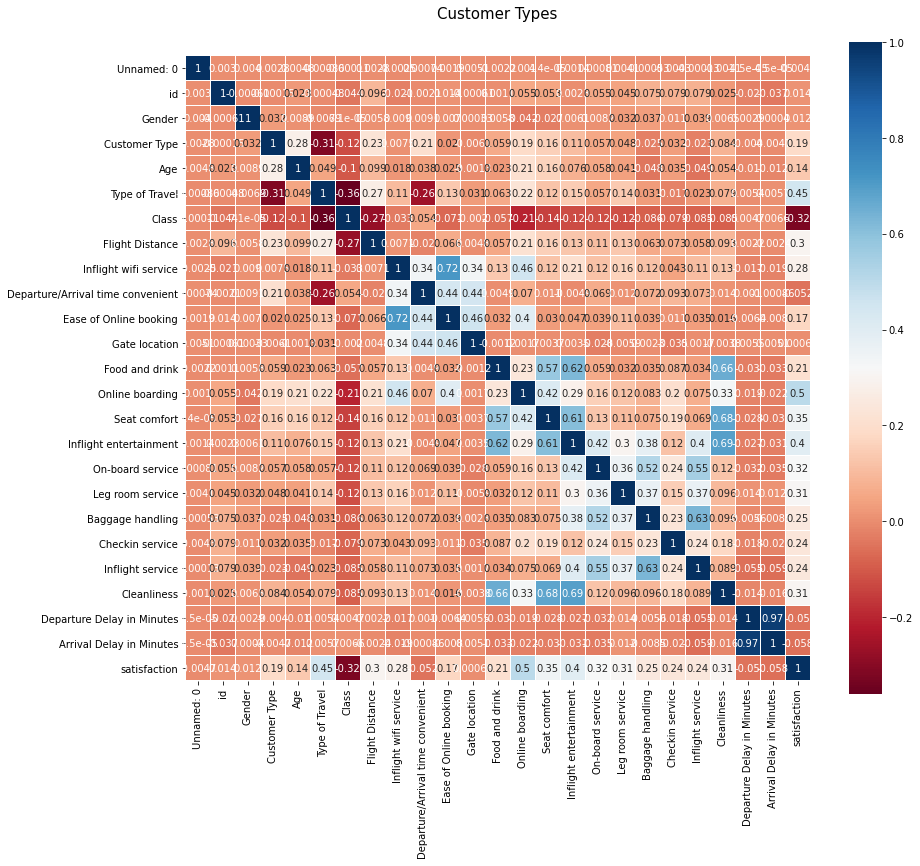

In [11]:
heatmap_data = train[train.columns]
plt.figure(figsize=(14, 12))
colormap = plt.cm.RdBu
plt.title('Customer Types', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0,square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={"size": 10})

#del heatmap_data

# 데이터 분석
Class와 데이터들간의 상관관계를 아래와 같이 볼 수 있다.
클래스 자체를 제외하고 매우 높은 상관관계나 매우 낮은 상관관계는 찾을 수 없다.
하지만 특정값이 연관이 있음을 도출 할 수 있다.

In [12]:
Class = train.corrwith(train['Customer Type'])
print(Class.sort_values())

Type of Travel                      -0.308333
Class                               -0.122325
Baggage handling                    -0.024723
Inflight service                    -0.022670
Gate location                       -0.006078
Arrival Delay in Minutes            -0.004747
Departure Delay in Minutes          -0.004036
id                                  -0.000145
Unnamed: 0                           0.002844
Inflight wifi service                0.007543
Ease of Online booking               0.019509
Gender                               0.031732
Checkin service                      0.032177
Leg room service                     0.047868
On-board service                     0.056560
Food and drink                       0.059454
Cleanliness                          0.083613
Inflight entertainment               0.109930
Seat comfort                         0.159484
satisfaction                         0.187638
Online boarding                      0.189262
Departure/Arrival time convenient 

# 연관없는 데이터 제거
아래 drop에 들어간 칼럼들을 제거 했다.  
이는 상관관계의 절댓값이 0.12이하인 것들을 제거하여 불필요한 연산을 줄여서 속도를 개선하였다.  
또한 test의 값인 Customer Type를 삭제하였다.

In [13]:
train.drop(['Checkin service','Gender','Ease of Online booking','Inflight service','Inflight wifi service','Baggage handling','Gate location', 'Arrival Delay in Minutes', 'Departure Delay in Minutes', 'id', 'Unnamed: 0', 'Inflight wifi service','Leg room service','On-board service','Food and drink','Cleanliness','Inflight entertainment'], axis=1, inplace=True)
test.drop(['Customer Type','Checkin service','Gender','Ease of Online booking','Inflight service','Inflight wifi service','Baggage handling','Gate location', 'Arrival Delay in Minutes', 'Departure Delay in Minutes', 'id', 'Unnamed: 0', 'Inflight wifi service','Leg room service','On-board service','Food and drink','Cleanliness','Inflight entertainment'], axis=1, inplace=True)

In [14]:
train.corrwith(train['Customer Type'])

Customer Type                        1.000000
Age                                  0.281674
Type of Travel                      -0.308333
Class                               -0.122325
Flight Distance                      0.225200
Departure/Arrival time convenient    0.206869
Online boarding                      0.189262
Seat comfort                         0.159484
satisfaction                         0.187638
dtype: float64

In [15]:
test.dtypes

Age                                  int64
Type of Travel                       int64
Class                                int64
Flight Distance                      int64
Departure/Arrival time convenient    int64
Online boarding                      int64
Seat comfort                         int64
satisfaction                         int64
dtype: object

In [16]:
train.dtypes

Customer Type                        int64
Age                                  int64
Type of Travel                       int64
Class                                int64
Flight Distance                      int64
Departure/Arrival time convenient    int64
Online boarding                      int64
Seat comfort                         int64
satisfaction                         int64
dtype: object

# 모델학습
현재 Customer Type은 1(Loyal Customer) , 0(disloyal Customer)로 이루어져 있다.
그러기 때문에 binary classfication문제로 해석된다.


In [17]:
# 패키지 임포트
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [18]:
X_train = train.drop('Customer Type', axis=1).values
target_label = train['Customer Type'].values
X_test = test.values
X_train.shape, X_test.shape

((103904, 8), (25976, 8))

In [19]:
X_tr, X_te, y_tr, y_te = train_test_split(X_train, target_label, test_size=0.2, random_state=42)

In [20]:
# null체크
np.where(np.isnan(X_tr))

(array([], dtype=int64), array([], dtype=int64))

# 랜덤 포레스트(디폴트값)

In [21]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_te)

In [22]:
print('총 {}명 중 {:.2f}% 정확도로 고객을 예측함'.format(y_te.shape[0], 100 * metrics.accuracy_score(prediction, y_te)))

총 20781명 중 95.45% 정확도로 고객을 예측함


랜덤 포레스트에 사용된 가중치를 보기

In [23]:
model.feature_importances_

array([0.21667044, 0.17412111, 0.05516427, 0.21074377, 0.1189783 ,
       0.07888246, 0.08557914, 0.05986051])

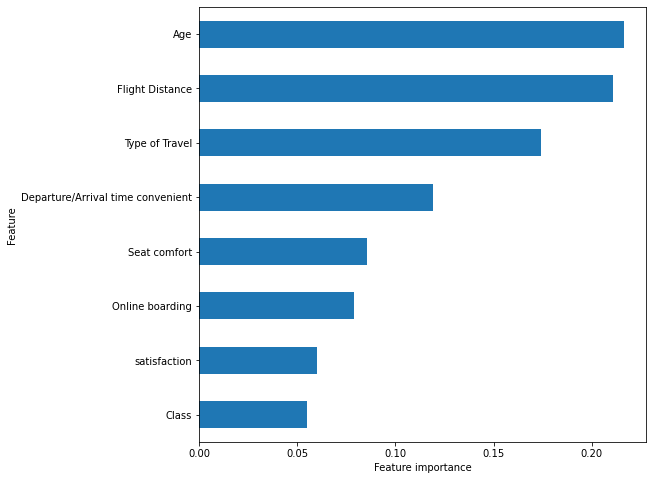

In [24]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=test.columns)
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

위의 순서대로 가중치를 두니 95.35%의 정확도가 나왔다.
